# Homework Starter — Stage 08 EDA

Fill in the marked TODOs. This notebook generates synthetic data so you can focus on the EDA flow. Replace with your dataset when ready.

In [38]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)

# === Synthetic data generator (adapt or replace with your own data) ===
n = 160
df = pd.DataFrame({
    'date': pd.date_range('2021-02-01', periods=n, freq='D'),
    'region': np.random.choice(['North','South','East','West'], size=n),
    'age': np.random.normal(40, 8, size=n).clip(22, 70).round(1),
    'income': np.random.lognormal(mean=10.6, sigma=0.3, size=n).round(2),
    'transactions': np.random.poisson(lam=3, size=n),
})
base = df['income'] * 0.0015 + df['transactions']*18 + np.random.normal(0, 40, size=n)
df['spend'] = np.maximum(0, base).round(2)

# inject a bit of missingness and outliers
df.loc[np.random.choice(df.index, 5, replace=False), 'income'] = np.nan
df.loc[np.random.choice(df.index, 3, replace=False), 'spend'] = np.nan
df.loc[np.random.choice(df.index, 2, replace=False), 'transactions'] = df['transactions'].max()+12
df.head()

,date,region,age,income,transactions,spend
0,2021-02-01,West,37.6,28086.81,4,73.35
1,2021-02-02,North,43.0,33034.75,1,52.37
2,2021-02-03,South,38.2,50045.39,2,131.85
3,2021-02-04,South,24.9,39467.28,4,147.58
4,2021-02-05,South,59.8,31201.65,1,86.76


## 1) First look

In [39]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          160 non-null    datetime64[ns]
 1   region        160 non-null    object        
 2   age           160 non-null    float64       
 3   income        155 non-null    float64       
 4   transactions  160 non-null    int32         
 5   spend         157 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int32(1), object(1)
memory usage: 7.0+ KB


(None,
 date            0
 region          0
 age             0
 income          5
 transactions    0
 spend           3
 dtype: int64)

## 2) Numeric profile

In [40]:
desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,160.0,40.018750,8.458676,22.00,34.70,40.15,44.925,61.10,0.069538,-0.080125
income,155.0,41983.866323,13262.457038,17928.80,32471.53,39332.52,49697.690,87052.40,0.993336,0.918722
transactions,160.0,3.237500,2.585610,0.00,2.00,3.00,4.000,20.00,3.466078,19.984802
spend,157.0,117.291592,51.768645,0.54,77.25,119.32,153.340,280.05,0.130860,-0.084917


## 3) Distributions

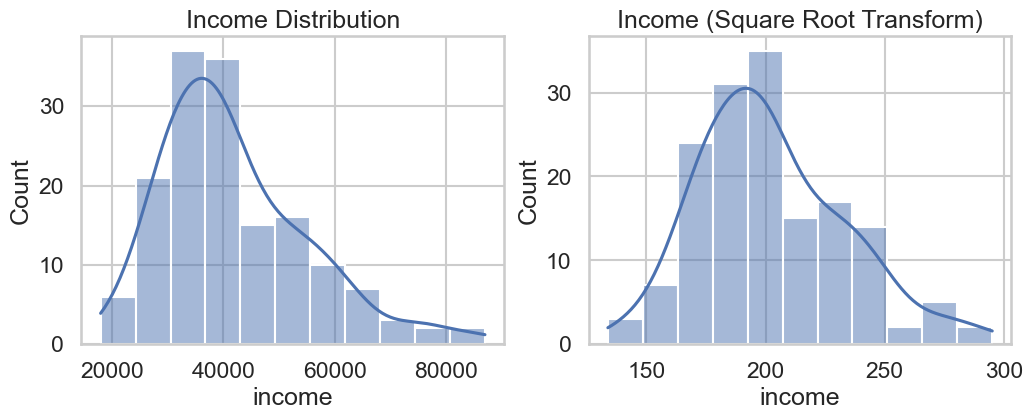

<Figure size 640x480 with 0 Axes>

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df["income"], kde=True, ax=axes[0])
axes[0].set_title("Income Distribution")

sns.histplot(np.sqrt(df["income"]), kde=True, ax=axes[1])
plt.title("Income (Square Root Transform)")
plt.show()

plt.tight_layout()
plt.show()

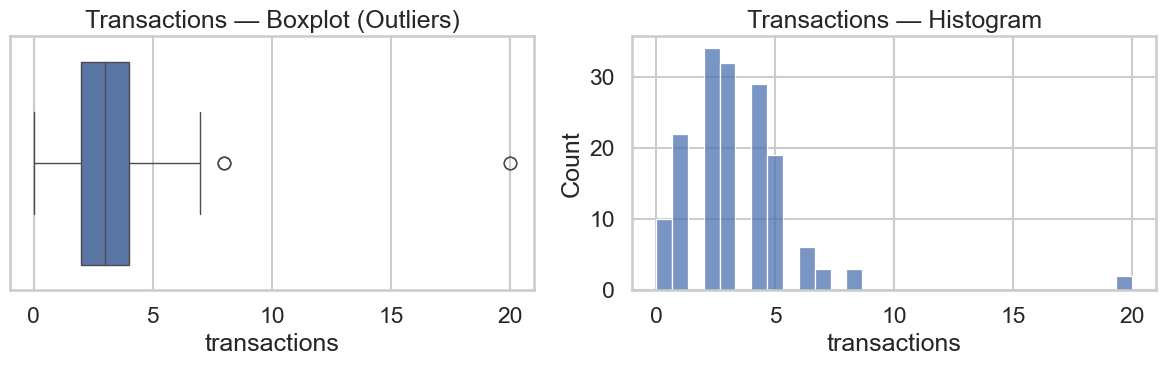

In [42]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(x=df["transactions"], ax=axes[0])
axes[0].set_title("Transactions — Boxplot (Outliers)")

sns.histplot(df["transactions"], bins=30, kde=False, ax=axes[1])
axes[1].set_title("Transactions — Histogram")

plt.tight_layout()
plt.show()

## 4) Relationships

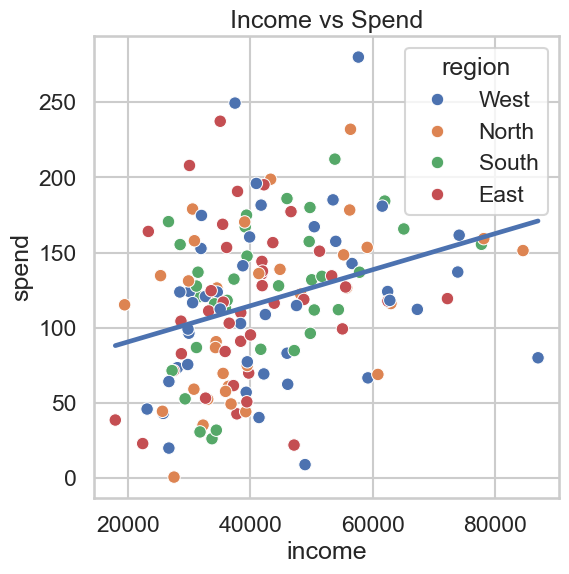

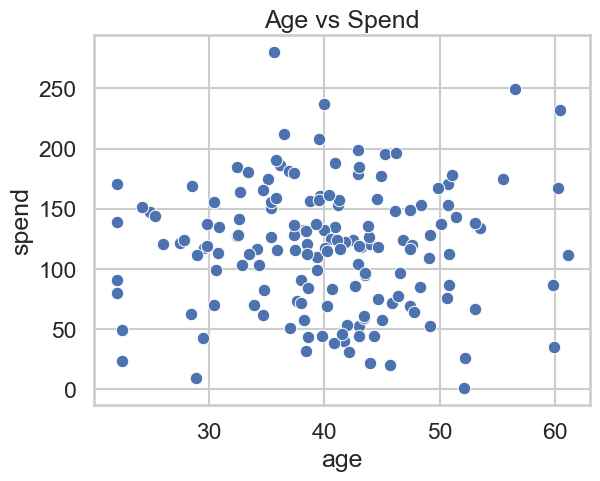

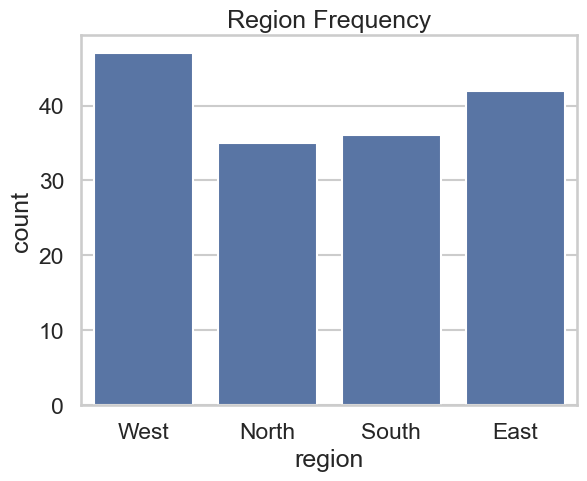

In [43]:

plt.figure(figsize=(6,6))

sns.scatterplot(data=df, x='income', y='spend', hue='region')
sns.regplot(data=df, x="income", y="spend", scatter=False, ci=None)
plt.title('Income vs Spend')
plt.show()

sns.scatterplot(data=df, x='age', y='spend')
plt.title('Age vs Spend')
plt.show()

sns.countplot(x=df['region'])
plt.title('Region Frequency')
plt.show()

## 5) Correlation matrix

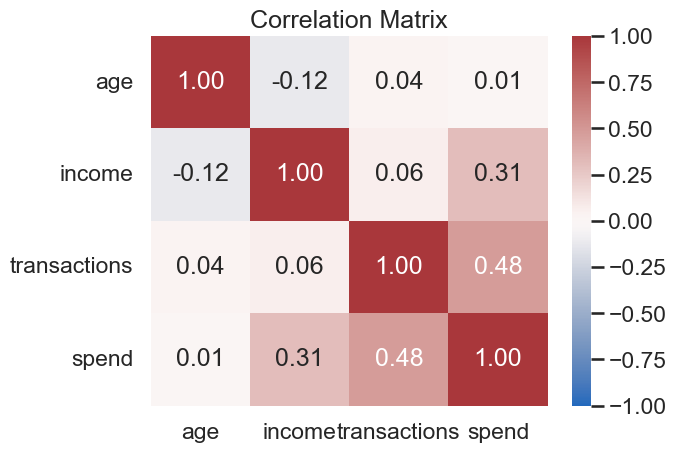

,age,income,transactions,spend
age,1.000000,-0.123160,0.037754,0.008174
income,-0.123160,1.000000,0.063573,0.307307
transactions,0.037754,0.063573,1.000000,0.480685
spend,0.008174,0.307307,0.480685,1.000000


In [44]:
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

In [45]:
def quick_profile(series: pd.Series) -> pd.Series:
    s_numeric = pd.to_numeric(series, errors="coerce")
    return pd.Series({
        "Number": s_numeric.count(),
        "Mean": s_numeric.mean(),
        "Median": s_numeric.median(),
        "Skewness": s_numeric.skew(),
        "Standard deviation": s_numeric.std(),
        "95th percentile": s_numeric.quantile(0.95),
        "99th percentile": s_numeric.quantile(0.99),
        "Percentage missing (%)": s_numeric.isna().mean() * 100
    })

# example usage
profile = pd.concat(
    {col: quick_profile(df[col]) for col in ["income", "transactions", "spend", "age"]},
    axis=1
)
profile.round(3)


,income,transactions,spend,age
Number,155.000,160.000,157.000,160.000
Mean,41983.866,3.238,117.292,40.019
Median,39332.520,3.000,119.320,40.150
Skewness,1.003,3.499,0.132,0.070
Standard deviation,13262.457,2.586,51.769,8.459
95th percentile,65766.471,6.050,195.240,53.120
99th percentile,81131.808,12.920,242.665,60.341
Percentage missing (%),3.125,0.000,1.875,0.000


## 6) Insights & Assumptions (write your commentary)
Top 3 insights:

The income variable is heavily skewed to the right.Most people have lower to mid-level incomes, while a small group has very high incomes that stretch the distribution

The transactions variable shows clear outliers in the boxplot -->a few individuals are making way more transactions than the majority.

Transformations like square root help make the skewed data look more balanced, which suggests they may be useful later when building models.

Assumptions & risks:

I assumed that the extreme values (very high incomes or transactions) might be “outliers” or errors, but it’s possible they represent real cases (e.g., wealthy individuals). Removing or clipping them could hide important signals.

I also assumed missing values can be handled later (either imputed or dropped) and that transformations are appropriate; but if the data aren’t numeric or have too many zeros/negatives, sqrt transforms won’t work properly.

Next steps before modeling (cleaning & features):

Handle missing values (decide whether to drop or impute them).
Decide on an outlier strategy: keep, winsorize, or remove.
Standardize or transform skewed variables (like income) to improve model stability.